# Imports & Downloads

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import BernoulliNB, MultinomialNB, ComplementNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

In [3]:
stop_words = stopwords.words()

# Loading the data

In [4]:
#  avoid characters of text column to be cut off by default Pandas DataFrame limitations
pd.set_option('display.max_colwidth', 400)

# -*- coding: utf-8 -*-

In [5]:
df_raw_val = pd.read_csv("C:\\Users\\admin\\PycharmProjects\\WebScience24\\data\\twitter_hate-speech\\test.csv",
                     index_col=0)
df_raw_val.head()

,tweet
id,
31963,#studiolife #aislife #requires #passion #dedication #willpower to find #newmaterialsâ¦
31964,@user #white #supremacists want everyone to see the new â #birdsâ #movie â and hereâs why
31965,safe ways to heal your #acne!! #altwaystoheal #healthy #healing!!
31966,"is the hp and the cursed child book up for reservations already? if yes, where? if no, when? ððð #harrypotter #pottermore #favorite"
31967,"3rd #bihday to my amazing, hilarious #nephew eli ahmir! uncle dave loves you and missesâ¦"


In [6]:
df_raw_train = pd.read_csv("C:\\Users\\admin\\PycharmProjects\\WebScience24\\data\\twitter_hate-speech\\train.csv",
                      index_col=0)
df_raw_train.head()

,label,tweet
id,,
1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
3,0,bihday your majesty
4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
5,0,factsguide: society now #motivation


# Preparing the data

In [7]:
df = df_raw_train

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31962 entries, 1 to 31962
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   31962 non-null  int64 
 1   tweet   31962 non-null  object
dtypes: int64(1), object(1)
memory usage: 749.1+ KB


## Duplicate-Check

In [9]:
df.duplicated().sum()

2432

In [10]:
df = df.drop_duplicates()
df.duplicated().sum()

0

## Null-Check

In [11]:
df.isna().sum()

label    0
tweet    0
dtype: int64

## Inconsistent text & typos

In [12]:
df.label.unique()

array([0, 1], dtype=int64)

## Outlier

In [13]:
# Spalte: Tweet
# Ansatz: prüfen, ob es Ausreißer bei der Länge und/oder bei der Wortzahl pro Tweets gibt
df["char_count"] = df["tweet"].str.len()
df["word_count"] = df["tweet"].str.split().str.len()
df = df.reset_index(drop=True)

C:\Users\admin\AppData\Local\Temp\ipykernel_1244\4036354668.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["char_count"] = df["tweet"].str.len()
C:\Users\admin\AppData\Local\Temp\ipykernel_1244\4036354668.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["word_count"] = df["tweet"].str.split().str.len()


In [14]:
df["char_count"].describe()

count    29530.000000
mean        85.260921
std         29.891332
min         11.000000
25%         63.000000
50%         89.000000
75%        108.000000
max        274.000000
Name: char_count, dtype: float64

Text(0, 0.5, 'Number of Tweets')

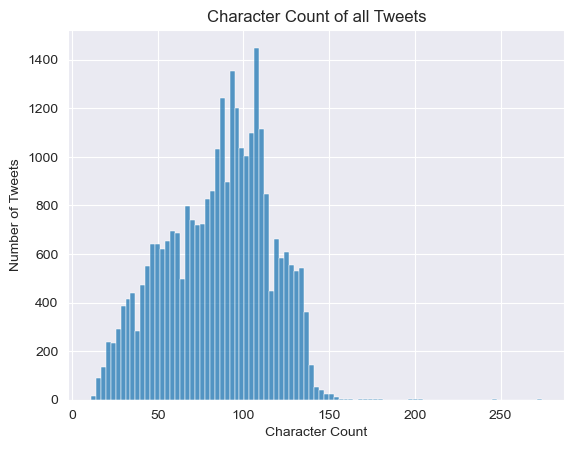

In [15]:
sns.histplot(df["char_count"])

plt.title('Character Count of all Tweets')

plt.xlabel('Character Count')
plt.ylabel('Number of Tweets')

Text(0, 0.5, 'Character Count')

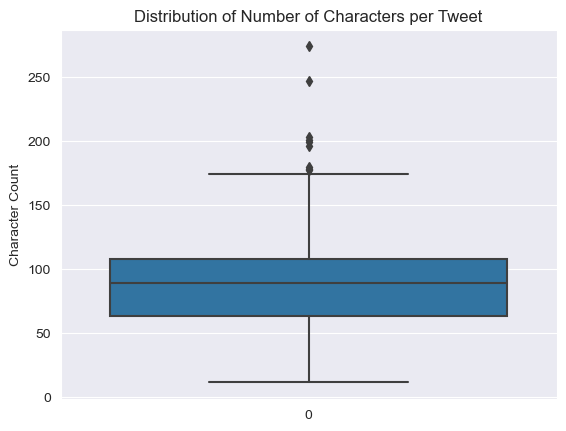

In [16]:
sns.boxplot(df["char_count"])

plt.title('Distribution of Number of Characters per Tweet')

plt.ylabel('Character Count')

In [17]:
df["word_count"].describe()

count    29530.000000
mean        13.255469
std          5.552220
min          3.000000
25%          9.000000
50%         13.000000
75%         17.000000
max         34.000000
Name: word_count, dtype: float64

Text(0, 0.5, 'Number of Tweets')

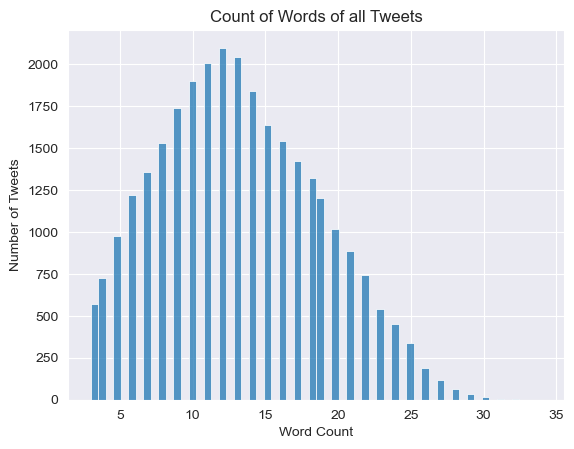

In [18]:
sns.histplot(df["word_count"])

plt.title('Count of Words of all Tweets')

plt.xlabel('Word Count')
plt.ylabel('Number of Tweets')

Text(0, 0.5, 'Number of Words')

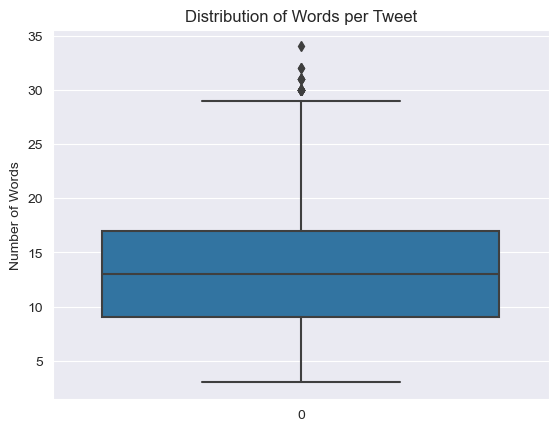

In [19]:
sns.boxplot(data=df["word_count"])

plt.title('Distribution of Words per Tweet')

plt.ylabel('Number of Words')

In [20]:
# Ausreißer auf numerische Art bestimmen: 3 Standardabweichungen vom Mittelwert entfernt = Ausreißer
def find_outlier(data):
    for num_col in data.select_dtypes(["number"]).columns:
        sd = data[num_col].std()
        mean = data[num_col].mean()
        result = [out for out in data[num_col] if (out > mean + 3 * sd) or (out < mean - 3 * sd)]
        print()
        print("Column: ", num_col)
        print("Mean: ", mean, "; Std: ", sd)
        print("Outlier: ", len(result), "; Values: ", sorted(result))

In [21]:
find_outlier(df[["char_count", "word_count"]])


Column:  char_count
Mean:  85.2609210971893 ; Std:  29.8913316290497
Outlier:  9 ; Values:  [177, 178, 180, 196, 199, 201, 203, 247, 274]

Column:  word_count
Mean:  13.255469014561463 ; Std:  5.55221975634696
Outlier:  26 ; Values:  [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 31, 32, 32, 34]


In [22]:
df[df["char_count"] >= 177]

,label,tweet,char_count,word_count
10651,0,@user st lucia â¢ socafrenzy ðð¿ðð¿ðð¿ â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢ #dj #djlife â¦,199,10
11284,0,oasis parkð¤bbq canvasâ³â³âµâ³âµ ððªð³ð¼ðð³ð¶ð½ð ðð¹ð¨ð»ð©ð»ð¶ðµðð â ðð¶ð¯ â #japan #gifu #dayoff #chill #loveâ¦,178,13
12682,0,awesom beautiful wonderfulððððððððððððð±ð±ð±ð±ð±ð±ðððððððððððððððððððððððððððððððððð»ð»ð»ð»,247,3
13747,0,@user âï¸ï¸ð¸donald trump âï¸ð¸was right again âï¸ð¸ð¨la razað¨ judge ð¨biasedð¨ âï¸ð¸weâ¤ï¸trump âï¸ð¸monday speech âï¸ð¸will be awesome,180,16
14303,0,"happy fasting,happy saturday, happy weekend happy holiday,always be happy everyday âðððððððð #days13 #ramadan ð³ðð¸ #morn #pagi ðâ¤ #2 #am",177,19
17251,0,@user rotterdam â¢ socafrenzy â¢ ðð¿ðð¿ðð¿ â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢ #dj #djlife â¦,203,10
18495,0,@user lmfao pathetic #soit #growup #funny #noonethere #iknowwhoitis ðððððððððððð¤ð¤ð¤ð¤ð¤ð¤ð¤ð¤ð¤ð¤ð¤ð¤ð±ð±ð¤ð¤ð±ð¤ð¤ð¤ð¤ð¤ð¤ð¤ð¤ð¤ð¤ð¤ð¤ð¤ð¤ð¤ðððððððâ¦,274,9
24286,0,rotterdam â¢ socafrenzy â¢ ðð¿ðð¿ðð¿ â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢â¢ #dj #djlife â¦,196,9
29092,0,&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt; #äºå®®åä¹ bihday #to #you #æãå«ã¹ #33æ­³â¦,201,7


In [23]:
df[df["word_count"] >= 30]

,label,tweet,char_count,word_count
227,1,"if you hold open a door for a woman because she's a woman and not because it's a nice thing to do, that's . don't even try to deny it",133,30
362,0,anas + nimra + farishta + mawia + khushal 960 + 952 + 503 + 484 + 435 = 3334 the number of marks obtained is too damn high :p,130,30
1683,0,"@user this summer is about to be crazy. i can already tell i'm going to have to stay out the way, and not show my face at too many eâ¦",136,30
2127,0,father's day # i m really vry lucky to hav u as my dad... u r my frnd my strength... n thank u for alywys suppobg me. luv u papa,130,30
5564,0,one exam :d even though i woke up at 5 to get my ass to an exam on time im not tired. is it the #cold or am i just for it to end?ð,135,34
7558,0,can't wait anymore ! ðð only a day left ! ðð @user ð well nt even tht ! it's 22 hrs 46 mins still ! ð can't control me now ð,147,31
10970,0,"@ a bar to watch the cavs and a guy hid something under his arm weirdly, so the baender asked him to show it, def scared it was a gun",135,30
11477,0,"life is what u make of it &amp; i choose 2 make mine a happy one, full of fun &amp; laughter n u r more than welcome 2 join me ð #lovemylife",145,32
14833,0,i'm just say i have a girlfriend and see how savage some of y'all really are . . . cause in 2016 . . . y'all really don't give. . .,133,31
15320,0,i needed money for parking but i only have my card so i looked on my car floor and came up w 3$ in change easy . i needa clean my carð©,139,32


=> Strategie: Einträge droppen, um ML Modelle nicht durch Ausreißer zu beeinflussen (bei DeepLearning-Modellen tendenziell irrelevant)

In [24]:
df = df[df["char_count"] < 177]
df[df["char_count"] >= 177]

,label,tweet,char_count,word_count


In [25]:
df = df[df["word_count"] < 30]
df[df["word_count"] >= 30]

,label,tweet,char_count,word_count


In [26]:
# df.drop(['Char_Count', 'Word_Count'], axis=1, inplace=True)

## Datensatz nach Bereinigung

In [27]:
print(df.count())
print(df_raw_train.count())
print(df.count() - df_raw_train.count())
print(df.count() / df_raw_train.count() - 1)

label         29495
tweet         29495
char_count    29495
word_count    29495
dtype: int64
label    31962
tweet    31962
dtype: int64
char_count       NaN
label        -2467.0
tweet        -2467.0
word_count       NaN
dtype: float64
char_count         NaN
label        -0.077185
tweet        -0.077185
word_count         NaN
dtype: float64


## Check Val/Test-Data

In [28]:
# df_val_raw = pd.read_csv("C:\\Users\\admin\\PycharmProjects\\WebScience24\\data\\twitter_hate-speech\\test.csv", index_col=0)
# TODO

## Save cleaned Data

In [29]:
filepath = Path("data/train_cleaned.csv")
filepath.parent.mkdir(parents=True, exist_ok=True)

In [30]:
df.to_csv(filepath)

# EDA

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29495 entries, 0 to 29529
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   label       29495 non-null  int64 
 1   tweet       29495 non-null  object
 2   char_count  29495 non-null  int64 
 3   word_count  29495 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.1+ MB


In [32]:
df.describe()

,label,char_count,word_count
count,29495.000000,29495.000000,29495.000000
mean,0.068215,85.179488,13.241024
std,0.252119,29.789917,5.530933
min,0.000000,11.000000,3.000000
25%,0.000000,63.000000,9.000000
50%,0.000000,89.000000,13.000000
75%,0.000000,108.000000,17.000000
max,1.000000,174.000000,29.000000


## Korrelationsanalyse

<Axes: >

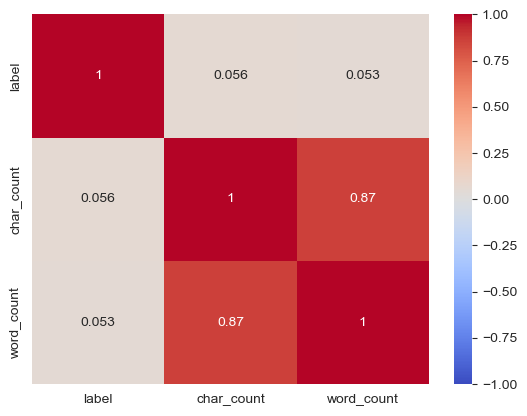

In [33]:
sns.heatmap(df.corr(numeric_only=True), annot=True, vmin=-1, vmax=1, cmap="coolwarm")

In [34]:
target_corr = df.corr(numeric_only=True)["label"]
target_corr.abs().sort_values(ascending=False)

label         1.000000
char_count    0.056464
word_count    0.052569
Name: label, dtype: float64

Korrelationsanalyse feature<->target => keine originären numerischen Werte, bei den erzeugten numerischen Werten keine nennenswerte Korrelation erkennbar

## Targetanalyse

In [35]:
df["label"].value_counts()

0    27483
1     2012
Name: label, dtype: int64

## Featureanalyse

<Axes: xlabel='word_count', ylabel='Count'>

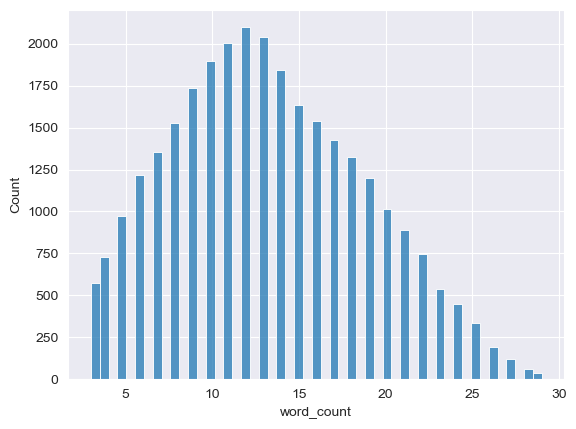

In [36]:
# Feature: Tweet
sns.histplot(df["word_count"])

<Axes: xlabel='char_count', ylabel='Count'>

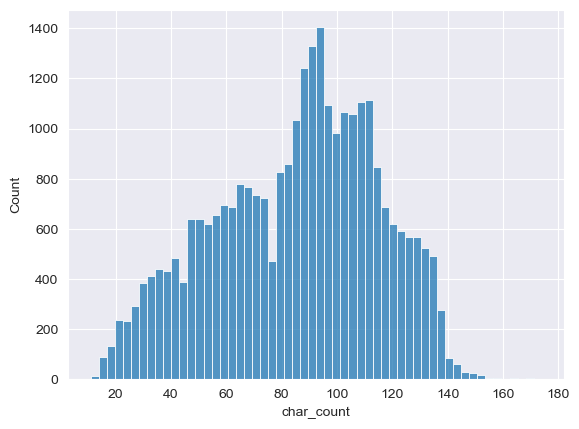

In [37]:
sns.histplot(df["char_count"])

## Feature x Target

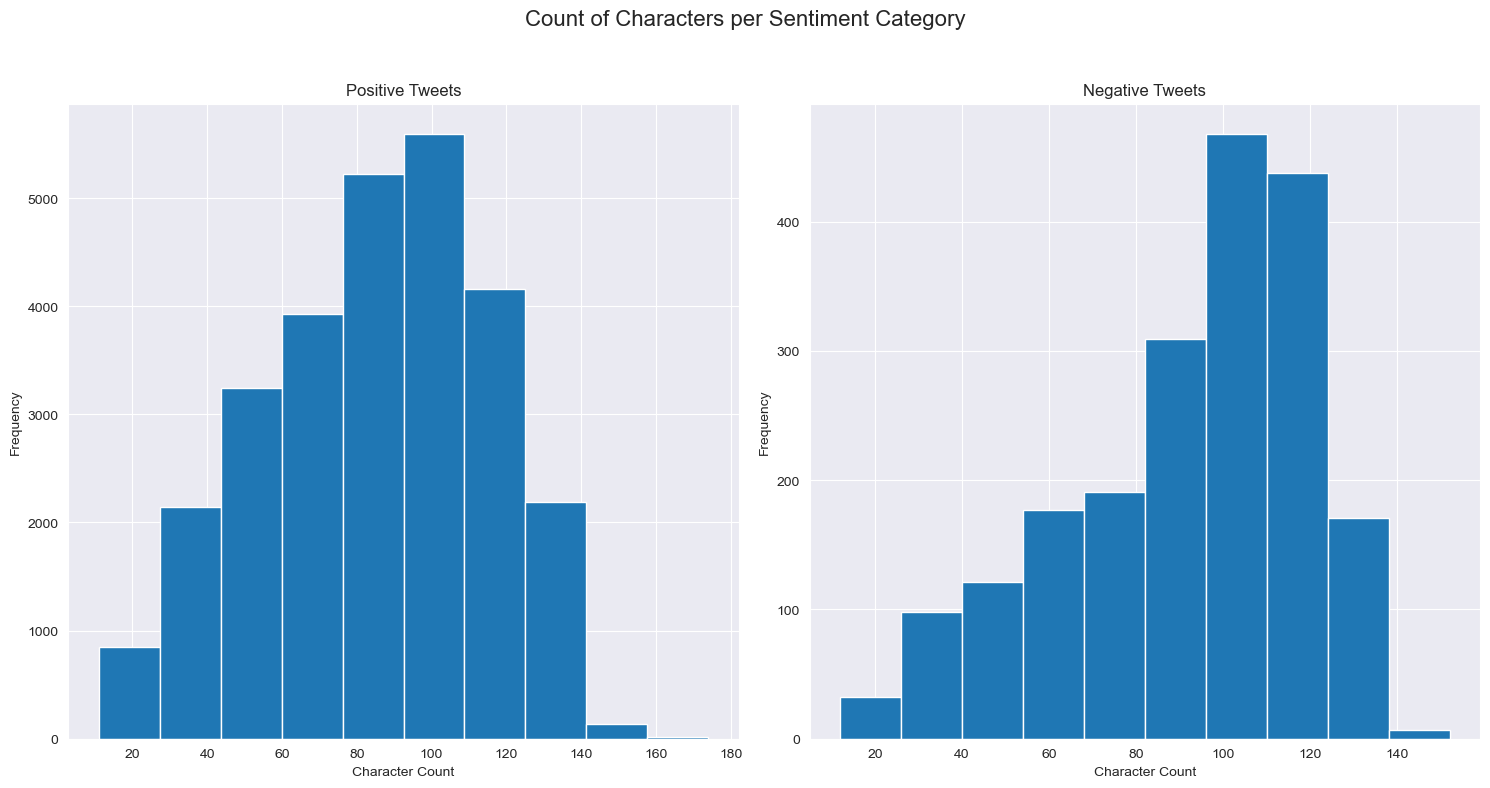

In [38]:
#Character Count

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# Positive Tweets
ax1.hist(df[df['label'] == 0]['char_count'])
ax1.set_title('Positive Tweets')
ax1.set_xlabel('Character Count')  
ax1.set_ylabel('Frequency')          

# Negative Tweets
ax2.hist(df[df['label'] == 1]['char_count'])
ax2.set_title('Negative Tweets')
ax2.set_xlabel('Character Count')  
ax2.set_ylabel('Frequency')

plt.suptitle('Count of Characters per Sentiment Category', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()

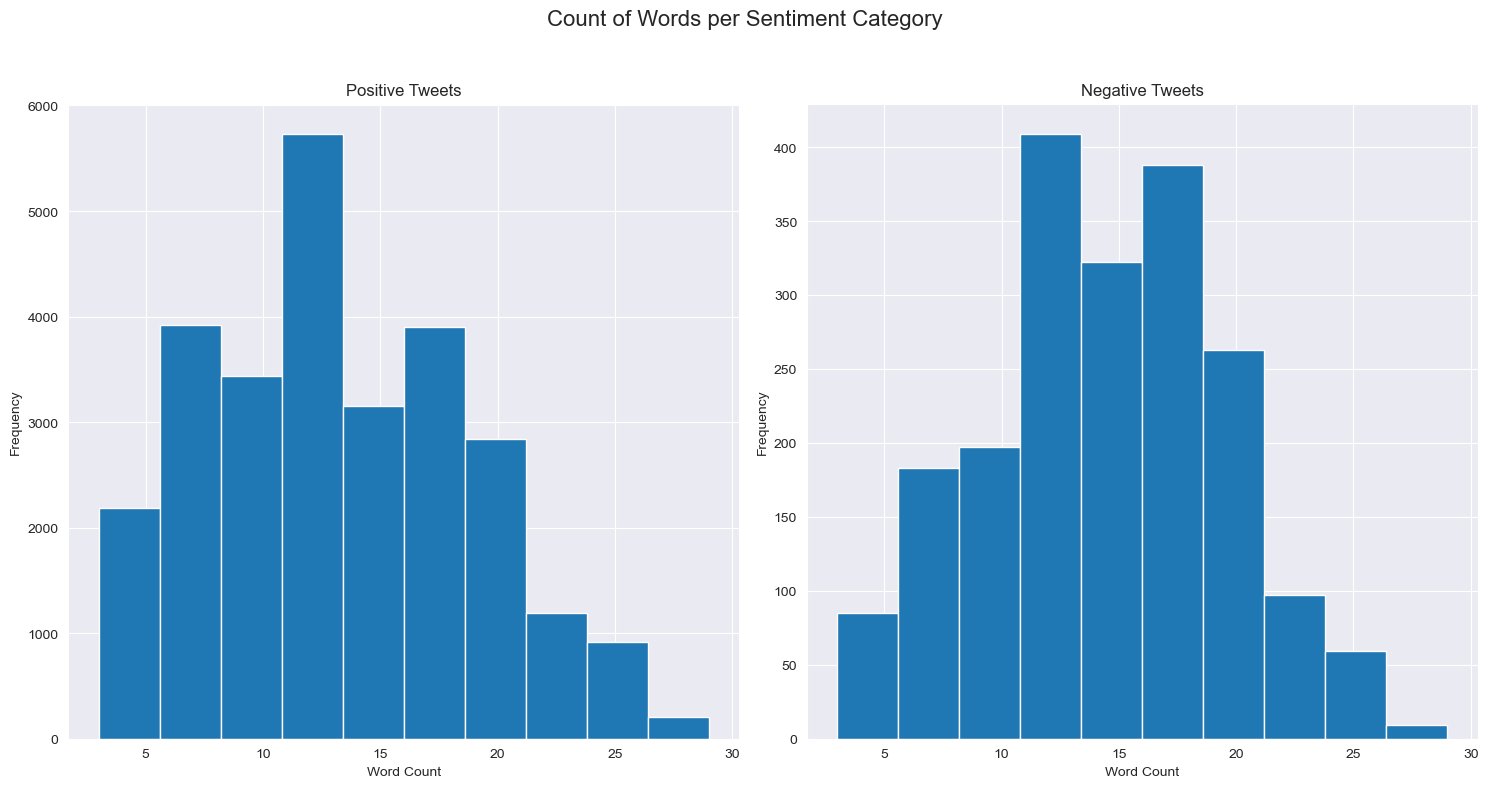

In [39]:
# Word Count

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# Positive Tweets
ax1.hist(df[df['label'] == 0]['word_count'])
ax1.set_title('Positive Tweets')
ax1.set_xlabel('Word Count')  
ax1.set_ylabel('Frequency')    

# Negative Tweets
ax2.hist(df[df['label'] == 1]['word_count'])
ax2.set_title('Negative Tweets')
ax2.set_xlabel('Word Count')  
ax2.set_ylabel('Frequency')

plt.suptitle('Count of Words per Sentiment Category', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()

# Data Preprocessing for Models

## Falsch codierte Character korrigieren

In [40]:
# TODO

## Text cleaning: emojis, toLower etc.

In [41]:
def cleaning(text):
    # converting to lowercase, removing URL links, special characters, punctuations...
    text = text.lower()  # converting to lowercase
    text = re.sub('https?://\S+|www\.\S+', '', text)  # removing URL links
    text = re.sub(r"\b\d+\b", "", text)  # removing number
    text = re.sub('<.*?>+', '', text)  # removing special characters,
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)  # punctuations
    text = re.sub('\n', '', text)
    text = re.sub('[’“”…]', '', text)

    #removing emoji:
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # removing short form:
    text = re.sub("isn't", 'is not', text)
    text = re.sub("he's", 'he is', text)
    text = re.sub("wasn't", 'was not', text)
    text = re.sub("there's", 'there is', text)
    text = re.sub("couldn't", 'could not', text)
    text = re.sub("won't", 'will not', text)
    text = re.sub("they're", 'they are', text)
    text = re.sub("she's", 'she is', text)
    text = re.sub("There's", 'there is', text)
    text = re.sub("wouldn't", 'would not', text)
    text = re.sub("haven't", 'have not', text)
    text = re.sub("That's", 'That is', text)
    text = re.sub("you've", 'you have', text)
    text = re.sub("He's", 'He is', text)
    text = re.sub("what's", 'what is', text)
    text = re.sub("weren't", 'were not', text)
    text = re.sub("we're", 'we are', text)
    text = re.sub("hasn't", 'has not', text)
    text = re.sub("you'd", 'you would', text)
    text = re.sub("shouldn't", 'should not', text)
    text = re.sub("let's", 'let us', text)
    text = re.sub("they've", 'they have', text)
    text = re.sub("You'll", 'You will', text)
    text = re.sub("i'm", 'i am', text)
    text = re.sub("we've", 'we have', text)
    text = re.sub("it's", 'it is', text)
    text = re.sub("don't", 'do not', text)
    text = re.sub("that´s", 'that is', text)
    text = re.sub("I´m", 'I am', text)
    text = re.sub("it’s", 'it is', text)
    text = re.sub("she´s", 'she is', text)
    text = re.sub("he’s'", 'he is', text)
    text = re.sub('I’m', 'I am', text)
    text = re.sub('I’d', 'I did', text)
    text = re.sub("he’s'", 'he is', text)
    text = re.sub('there’s', 'there is', text)

    return text

In [42]:
dt = df['tweet'].apply(cleaning)

In [43]:
dt = pd.DataFrame(dt)
dt['label'] = df['label']

In [44]:
dt.head()

,tweet,label
0,user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction run,0
1,user user thanks for lyft credit i cant use cause they dont offer wheelchair vans in pdx disapointed getthanked,0
2,bihday your majesty,0
3,model i love u take with u all the time in urð± ðððð ð¦ð¦ð¦,0
4,factsguide society now motivation,0


## Stopwords

In [45]:
dt['no_sw'] = dt['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [46]:
dt.head(20)

,tweet,label,no_sw
0,user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction run,0,user father dysfunctional selfish drags kids dysfunction run
1,user user thanks for lyft credit i cant use cause they dont offer wheelchair vans in pdx disapointed getthanked,0,user user lyft credit offer wheelchair vans pdx disapointed getthanked
2,bihday your majesty,0,bihday majesty
3,model i love u take with u all the time in urð± ðððð ð¦ð¦ð¦,0,model love time urð± ðððð ð¦ð¦ð¦
4,factsguide society now motivation,0,factsguide society motivation
5,huge fan fare and big talking before they leave chaos and pay disputes when they get there allshowandnogo,0,huge fare big talking leave chaos pay disputes allshowandnogo
6,user camping tomorrow user user user user user user user dannyâ¦,0,user camping tomorrow user user user user user user user dannyâ¦
7,the next school year is the year for examsð¯ cant think about that ð­ school exams hate imagine actorslife revolutionschool girl,0,school year year examsð¯ ð­ school exams hate imagine actorslife revolutionschool girl
8,we won love the land allin cavs champions cleveland clevelandcavaliers â¦,0,love land allin cavs champions cleveland clevelandcavaliers â¦
9,user user welcome here im its so gr8,0,user user welcome gr8


## Most frequent words

In [47]:
cnt = Counter()
for text in dt["no_sw"].values:
    for word in text.split():
        cnt[word] += 1
cnt.most_common(20)
temp = pd.DataFrame(cnt.most_common(20))
temp.columns = ['word', 'count']

In [48]:
temp.head(20)

,word,count
0,user,17100
1,love,2174
2,day,2097
3,happy,1546
4,amp,1480
5,life,1038
6,today,961
7,â¦,905
8,bihday,810
9,time,772


most frequent words erstmal nicht entfernen

In [49]:
# FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
# def remove_freqwords(text):
#     return " ".join([word for word in str(text).split() if word not in FREQWORDS])
# dt["no_sw_no_freqwo"] = dt["no_sw"].apply(lambda text: remove_freqwords(text))

In [50]:
# dt.head()

In [51]:
# dt[dt.no_sw != dt.no_sw_no_freqwo].head()

## Lemmatization

In [52]:
wordnet_lem = WordNetLemmatizer()
dt['no_sw_lem'] = dt['no_sw'].apply(wordnet_lem.lemmatize)

In [53]:
dt.head()

,tweet,label,no_sw,no_sw_lem
0,user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction run,0,user father dysfunctional selfish drags kids dysfunction run,user father dysfunctional selfish drags kids dysfunction run
1,user user thanks for lyft credit i cant use cause they dont offer wheelchair vans in pdx disapointed getthanked,0,user user lyft credit offer wheelchair vans pdx disapointed getthanked,user user lyft credit offer wheelchair vans pdx disapointed getthanked
2,bihday your majesty,0,bihday majesty,bihday majesty
3,model i love u take with u all the time in urð± ðððð ð¦ð¦ð¦,0,model love time urð± ðððð ð¦ð¦ð¦,model love time urð± ðððð ð¦ð¦ð¦
4,factsguide society now motivation,0,factsguide society motivation,factsguide society motivation


In [54]:
dt[dt.no_sw != dt.no_sw_lem].head(500)

,tweet,label,no_sw,no_sw_lem
1767,do what makes you,0,makes,make
3083,he got you two rings just be,0,rings,ring
3916,this makes me so,0,makes,make
5453,many many americans thats right,0,americans,american
5796,well said tubes,0,tubes,tube
6311,what makes me please let me know,1,makes,make
8023,this makes me so,0,makes,make
9440,schools almost over,0,schools,school
9612,are they twins,0,twins,twin
9619,all i know are souls,0,souls,soul


## Check again: Duplicates / NaN

In [55]:
dt.duplicated().sum()

78

In [56]:
dt.drop_duplicates(inplace=True)
dt.duplicated().sum()

0

In [57]:
dt.isna().sum()

tweet        0
label        0
no_sw        0
no_sw_lem    0
dtype: int64

In [58]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29417 entries, 0 to 29529
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      29417 non-null  object
 1   label      29417 non-null  int64 
 2   no_sw      29417 non-null  object
 3   no_sw_lem  29417 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.1+ MB


## Save preprocessed data

In [59]:
filepath = Path("data/train_cleaned_preprocessed.csv")
filepath.parent.mkdir(parents=True, exist_ok=True)

In [60]:
dt.to_csv(filepath)